# Dither Raster Plotting Notebook

This is a notebook for use by observers to plot dither sequences. It will show the SNR in each fiber for a sequence of spectrograph exposures. In addition to a range of spectrograph exposure numbers, you will also need to supply the ID of the PMX sequence used to initiate the raster scan.

In [1]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

import os
import dithering
from find_exposures import find_exposures

from astropy.table import join

## Access PMX Sequence

Get the PMX exposure you want and then read in the corresponding fiberassign file from `/exposures/desi`. The `find_exposures` module will do most of the work for you.

*** ALL you need to change here is the pmx_id ***

In [2]:
pmx_id = 32638
pmx_rec = find_exposures(exp_id=pmx_id, seq='PMX')
id_, date_, seq_, prog_ = pmx_rec[0]
fassign_tab = dithering.get_pmx_fiberassign_table(date_, id_)
fassign_tab

FIBER,TARGETID,LOCATION,FIBERSTATUS,TARGET_RA,TARGET_DEC,FIBERASSIGN_X,FIBERASSIGN_Y
int32,int64,int32,int32,float64,float64,float32,float32
400,611652141211189727,0,0,130.5832186117783,62.46659165050047,-1.3965654,-25.16333
449,611652141211189409,1,0,130.61612980752486,62.398929330682094,-5.051714,-41.644505
420,35191388907766334,2,0,130.57259344310594,62.42704706543156,-0.1675729,-34.7831
401,2305843016977361676,3,0,130.6769926434641,62.35981092949191,-11.897673,-51.19072
403,35191386089196417,4,0,130.5713511810855,62.37093904810379,0.0209234,-48.445217
427,611652138392618020,5,0,130.71305374641165,62.35070943280349,-15.967634,-53.416737
412,611652138392617958,6,0,130.56941371271148,62.33183647825533,0.27379936,-57.973667
447,611652138392618035,7,0,130.47247724664538,62.35099932428149,11.20601,-53.25673
437,611652138392617775,8,0,130.70611176155919,62.29780580587112,-15.169874,-66.31623


## Access Spectrograph Exposures

Supply a range of spectrograph exposures and then get the record data for each using a call to `find_exposures`. The `dithering` module will then grab the corresponding QA FITS file from Nightwatch and pull out the `PER_CAMFIBER` table for you, which contains the SNR for each fiber, for each exposure.

*** ALL you need to change here is the list of spec_ids ***

In [3]:
spec_ids = np.arange(32640, 32661)
spec_recs = find_exposures(exp_id=spec_ids, seq='Spectrographs')

In [4]:
camfiber_tabs = {}
max_snr = -1e99

for rec in spec_recs:
    # Get PER_CAMFIBER table from Nightwatch
    id_, date_, seq_, prog_ = rec
    camfiber_tab = dithering.get_camfiber_table(date_, id_)
    
    # Use only the B camera.
    bmask = camfiber_tab['CAM'] == 'B'
    
    # Join PER_CAMFIBER table with FASSIGN table.
    camfiber_tab = join(camfiber_tab[bmask], fassign_tab, keys='FIBER')
    camfiber_tabs[id_] = camfiber_tab
    
    # Store the max_snr across all exposures, which is handy for plotting down below.
    max_snr = np.maximum(max_snr, np.max(camfiber_tab['MEDIAN_CALIB_SNR']))

In [5]:
exposure_data = camfiber_tabs[32640]
exposure_data

FIBER,MEDIAN_CALIB_SNR,CAM,TARGETID,LOCATION,FIBERSTATUS,TARGET_RA,TARGET_DEC,FIBERASSIGN_X,FIBERASSIGN_Y
int64,float64,bytes1,int64,int32,int32,float64,float64,float32,float32
0,0.09761829742471738,B,35191377482482005,311,0,129.908687819977,61.40380805028346,79.882324,-289.78873
1,0.1444692514576555,B,611652129790099900,272,0,130.07193188110722,61.4593883024293,60.0948,-275.4084
2,0.10224007884035832,B,35191377486677392,252,0,130.33198938147268,61.465620739496764,29.194675,-273.88858
3,0.09891617784617887,B,35191380376551917,156,0,130.58333834508858,61.66021159353667,-0.75792414,-224.23521
4,0.16060558250256074,B,611652129794294509,198,0,130.74778499246648,61.527536447374395,-20.060085,-258.12296
5,0.16409751156335659,B,35191377486679178,204,0,130.24407772731885,61.601597881335934,39.14692,-238.9756
6,0.20165594644673018,B,611652129794294350,233,0,130.48394575580969,61.48939233705453,11.141201,-267.81674
7,0.26597940018066574,B,611652132679975067,172,0,130.4465611694003,61.654546656317265,15.256228,-225.61191
8,0.15164852022713357,B,35191377486676711,310,0,130.00295422585336,61.41981434989785,68.52295,-285.64777


## Plot SNR for the Spectrograph Raster Sequence

Loop through all of the camfiber data and plot the SNR in each exposure on the focal plane.

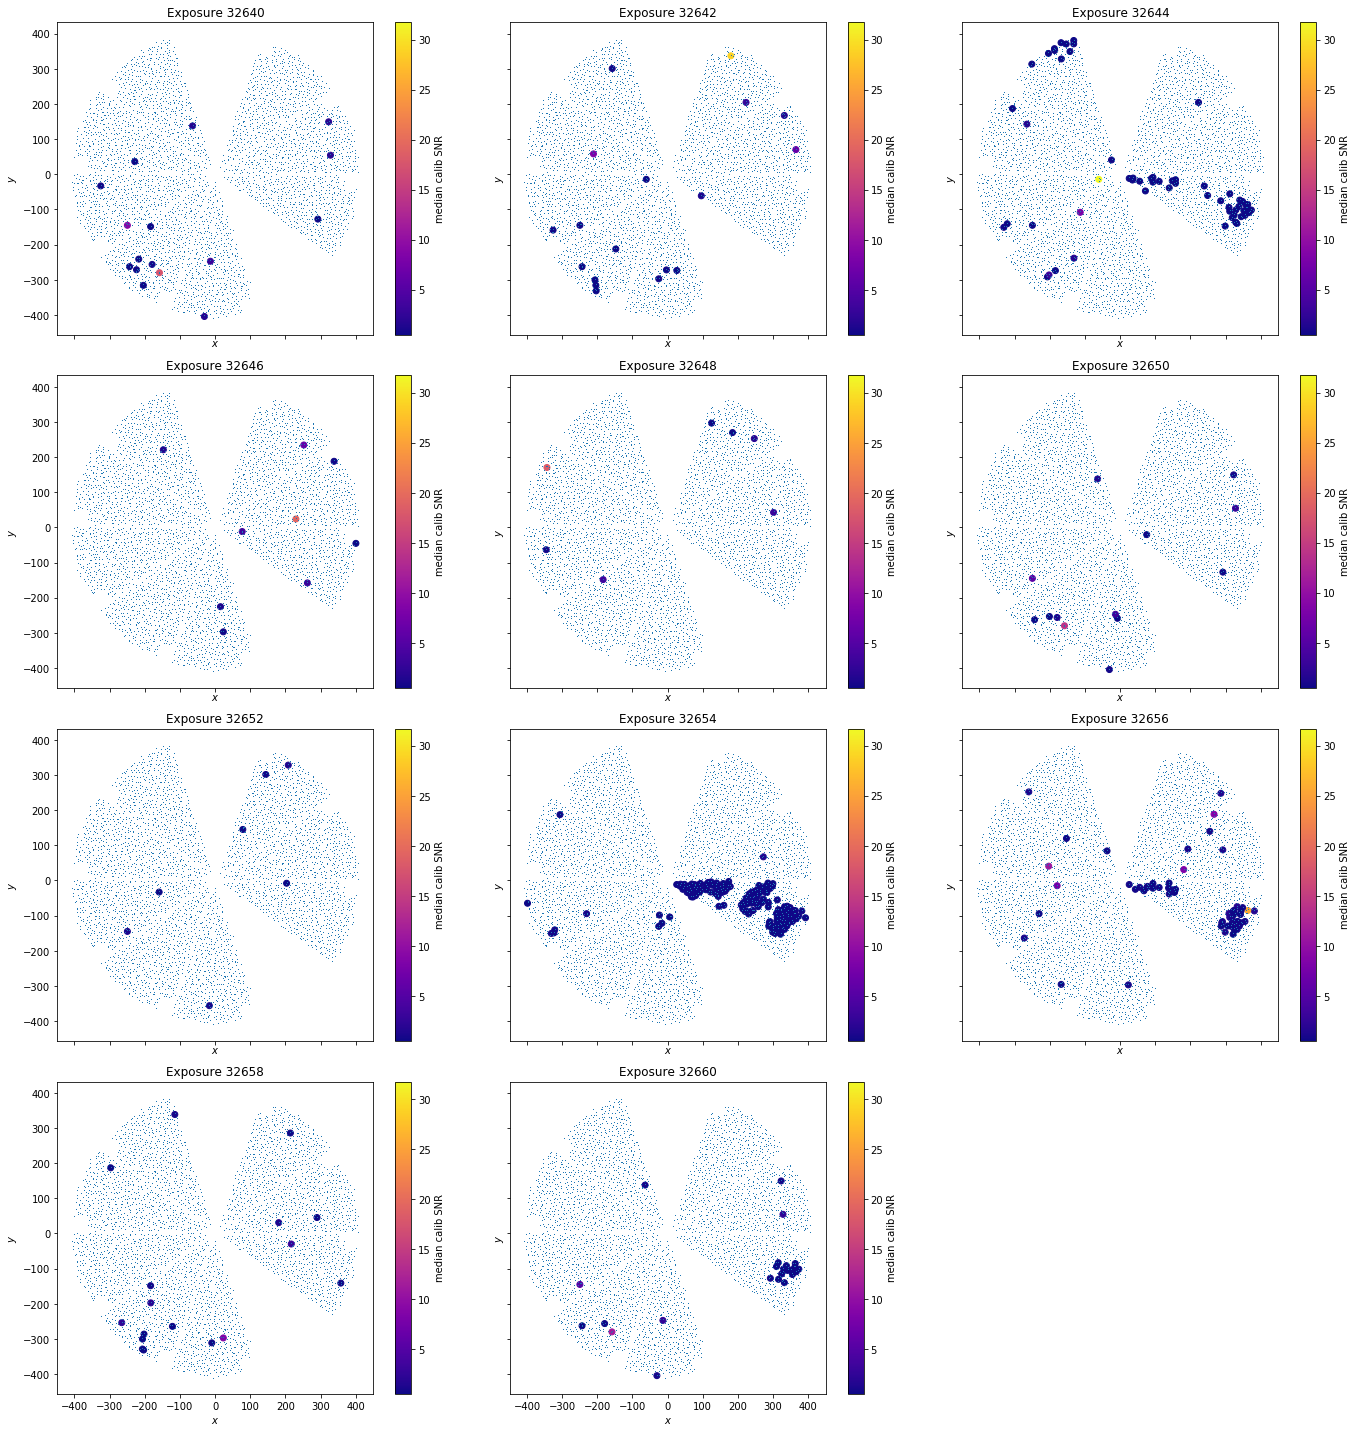

In [6]:
fig, axes = plt.subplots(4,3, figsize=(6.5*3, 5*4), sharex=True, sharey=True)
axes = axes.flatten()

n = len(axes)
m = len(camfiber_tabs)
if n > m:
    for i in range(m, n):
        axes[i].set_visible(False)  

for i, (exp_id, data) in enumerate(camfiber_tabs.items()):
    ax = axes[i]
    
    x = data['FIBERASSIGN_X']
    y = data['FIBERASSIGN_Y']
    snr = data['MEDIAN_CALIB_SNR']
    snr_cut = snr > 0.5

    ax.plot(x, y, ',')
    sc = ax.scatter(x[snr_cut], y[snr_cut], c=snr[snr_cut], cmap='plasma', vmax=max_snr)
    cb = fig.colorbar(sc, ax=ax)
    cb.set_label('median calib SNR')

    ax.set(aspect='equal',
           xlabel='$x$',
           ylabel='$y$',
           title='Exposure {}'.format(exp_id))  

fig.savefig('raster_snr.png')
fig.tight_layout()